In [1]:
from aicspylibczi import CziFile
import czifile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.animation as animation
import IPython
from IPython.display import HTML
import ffmpeg

In [2]:
from scipy.stats import sigmaclip
from multiprocessing import Pool
import os
import cv2
import skimage
import skimage.measure as skm
from skimage.measure import label, regionprops_table # version at least 0.22
from skimage.filters import threshold_otsu # version at least 0.22

In [3]:
from utils import *

In [4]:
processed_video_files = [
    ("processed", 3),
    ('processed', 6),
    ('processed', 9),
]
mip_video_files = [
    ('mip', 3),
    ('mip', 6),
    ('mip', 9),
]

In [5]:
class VideoDataMIP:
    def __init__(self, files):
        self.data = {
        }
        
        for category, num in files:
            print(f"Loading in MIP {num}")
            assert category == 'mip', "Can't load non Mip file"
            file = {}
            file['video'] = get_file(category, num)
            
            frames, shp = file['video'].read_image(C=0)
            frames = scale_img(frames.squeeze())
            file['frames'] = frames
            print(f"frames {num}: {frames.shape}")
            file['masks'] = binarize_video(frames)

            self.data[num] = file


    def extract_all_traces(self, file_num, sequence_length=-1, hist_length=2):
        # hist length is how many frames of history
        frames, masks = self.data[file_num]['frames'], self.data[file_num]['masks']
        N = len(frames)
        s = 0
        all_traces = []
        all_videos = []
        if(sequence_length < 0):
            data, videos = extract_traces(frames, masks, hist=hist_length)
        else:
            for i in range(N // sequence_length):
                #print(f"Extracting traces from {s}:{s+sequence_length}")
                data, videos = extract_traces(frames[s:s+sequence_length], masks[s:s+sequence_length], hist=hist_length)
                s += sequence_length
                all_traces = all_traces + data
                all_videos = all_videos + videos
            
            if(N % sequence_length > 0):
                data, videos = extract_traces(frames[-1*sequence_length:], masks[-1*sequence_length:], hist=hist_length)
                all_traces = all_traces + data
                all_videos = all_videos + videos

        self.data[file_num]['traces'] = all_traces
        self.data[file_num]['trace_videos'] = all_videos

In [6]:
videos = VideoDataMIP([mip_video_files[0]])

Loading in MIP 3
Loading dicty_factin_pip3-03_MIP.czi with dims [{'X': (0, 474), 'Y': (0, 2048), 'C': (0, 2), 'T': (0, 90)}]
frames 3: (90, 2048, 474)


In [7]:
VideoDataMIP.extract_all_traces(videos, 3, 10, 4)

In [8]:
mip3 = videos.data[3]

In [9]:
mip3.keys()

dict_keys(['video', 'frames', 'masks', 'traces', 'trace_videos'])

In [10]:
binary = mip3['traces'][10]['masks'][7].astype(np.uint8)

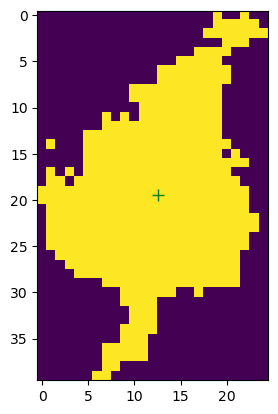

In [12]:
imshow(binary)

c = skm.centroid(binary)
plt.plot(c[1], c[0], 'g+', markersize=8)
plt.show()

In [9]:
def get_centroids(cell_data):
    boxes, masks = np.array(cell_data['boxes']), cell_data['masks']
    N = len(masks)
    res = []
    centroids = [skm.centroid(binary.astype(np.uint8)) for binary in masks]
    for i in range(N):
        c = centroids[i]
        ymin, xmin = boxes[i][:2]
        res.append([xmin+c[0], ymin+c[1]])
    return(np.array(res) - res[0])

In [24]:
mip3['trace_videos'][23][0].shape

(2048, 474)

In [27]:
anim = animate_frames(mip3['trace_videos'][19])
HTML(anim.to_html5_video())

In [15]:
mip3['traces'][19]['boxes']

[(1358, 261, 1451, 327),
 (1360, 263, 1459, 329),
 (1358, 262, 1458, 328),
 (1359, 262, 1459, 327),
 (1361, 262, 1457, 326),
 (1360, 261, 1462, 325),
 (1362, 261, 1457, 326),
 (1369, 261, 1456, 326),
 (1373, 260, 1459, 326),
 (1372, 260, 1457, 325)]

In [16]:
get_centroids(mip3['traces'][19])

array([[ 0.        ,  0.        ],
       [ 2.14453478,  1.44532881],
       [ 2.0977131 , -0.30890446],
       [ 0.75372983, -0.42562277],
       [ 1.58218811,  1.36786963],
       [ 2.23199063,  1.08516165],
       [-0.0614235 ,  2.90800744],
       [-3.79985221,  8.16175288],
       [-5.35399321, 13.05310857],
       [-5.17133232, 11.18252207]])

In [18]:
get_centroids(mip3['traces'][23])

[array([12.70052083, 19.74348958]), array([20.4506232 , 25.46596357]), array([16.17277487, 25.05584642]), array([14.35477178, 19.96473029]), array([10.92405063,  9.49367089]), array([12.13293051,  7.83987915]), array([79.49151527, 25.38790178]), array([80.68148731, 33.61951603]), array([62.92772926, 30.88427948]), array([61.58061139, 32.89321608])]


In [10]:
def plot_trajectory(cell_data):
    loc = get_centroids(cell_data)
    xs, ys = loc[:,0], loc[:,1]
    plt.plot(xs, ys, 'bo')
    plt.plot(xs, ys, 'r--')
    plt.plot(xs[0], ys[0], 'g*', markersize=10, label='Start')
    plt.legend()
    plt.show()

In [27]:
anim = animate_frames(mip3['traces'][31]['patches'])
HTML(anim.to_html5_video())

In [33]:
anim = animate_frames(mip3['trace_videos'][31])
HTML(anim.to_html5_video())

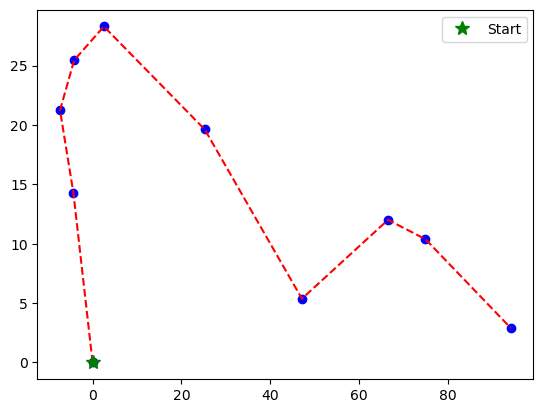

In [18]:
plot_trajectory(mip3['traces'][30])

In [26]:
anim = animate_frames(mip3['trace_videos'][12])
HTML(anim.to_html5_video())

## Pixel Intensity Analysis

In [34]:
demo_vid[0].max()

0.5840648210668468

In [33]:
np.histogram(demo_vid[0], bins=3)

(array([206, 353,  85]),
 array([0.02970966, 0.21449471, 0.39927977, 0.58406482]))

In [25]:
j = 18
demo_vid = mip3['traces'][j]['patches']

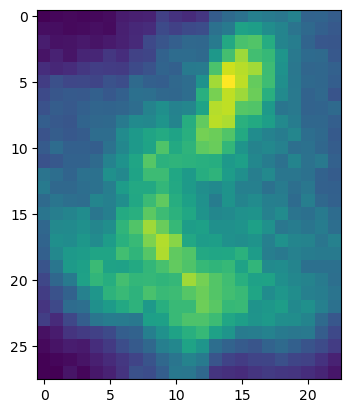

In [26]:
imshow(demo_vid[0])

In [16]:
len(demo_vid)

10

array([0.02970966, 0.21449471, 0.39927977, 0.58406482])

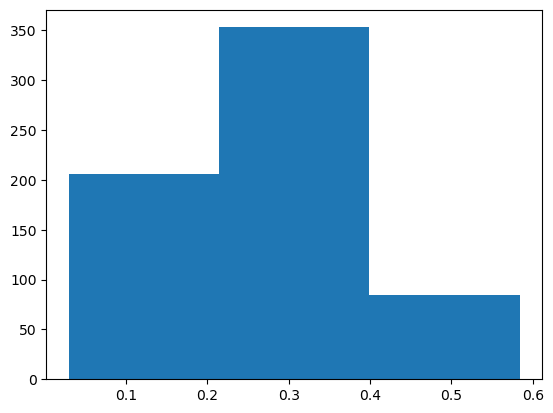

In [31]:
n, bins, fig = plt.hist(demo_vid[0].flatten(), bins=3, density=False)


bins


In [28]:
thresholds

[(0.21449471078100382, 0.3992797659239253),
 (0.19603871258158898, 0.36844474454197607),
 (0.2007652487058294, 0.3684447445419761),
 (0.20234076074724283, 0.3688948908395228),
 (0.19041188386225522, 0.35584064821066846),
 (0.21066846725185684, 0.3855503038487508),
 (0.19356290794508219, 0.3614674769300023),
 (0.19626378573036235, 0.3688948908395228),
 (0.1868107134818816, 0.35066396578888137),
 (0.20571685797884312, 0.37632230474904343)]

In [24]:
thresholds

[(0.33828494260634706, 0.6691424713031735),
 (0.3387350889038938, 0.6693675444519469),
 (0.3387350889038938, 0.6693675444519469),
 (0.3387350889038938, 0.6693675444519469),
 (0.3387350889038938, 0.6693675444519469),
 (0.33828494260634706, 0.6691424713031735),
 (0.33828494260634706, 0.6691424713031735),
 (0.33963538149898714, 0.6698176907494936),
 (0.33963538149898714, 0.6698176907494936),
 (0.3405356740940806, 0.6702678370470403)]

In [55]:
bins

array([0.00742741, 0.33828494, 0.66914247, 1.        ])

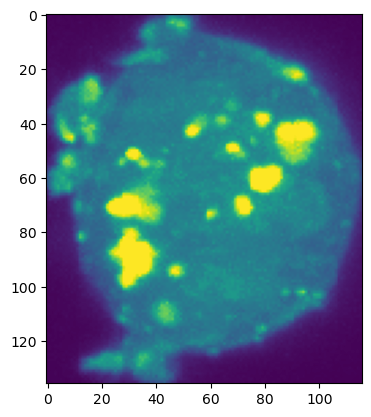

In [65]:
imshow(demo_vid[3])

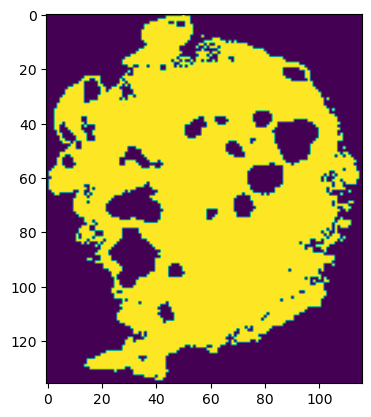

In [66]:
imshow(np.logical_and(0.338 < demo_vid[3], demo_vid[3] < 0.67))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Cell Featurization

In [18]:
import mahotas
import scipy
from scipy.spatial import distance
import skimage.measure as sk

In [19]:
mip3 = videos.data[3]['traces']
len(mip3)

67

In [11]:
image, binary = mip3[2]['patches'][0], mip3[2]['masks'][0].astype(np.uint8) 
image.shape, binary.shape

((142, 104), (142, 104))

In [11]:
def shape_features(binary, feature_length=20, num_samples=180):
    def radial_distance(binary, theta):
        height, width = binary.shape
        center = [width // 2, height // 2]
        def test_r(r):
            x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
            if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
                return(False)
            return(binary[int(y_test), int(x_test)])
        # calculate distance to the nearest pixel
        r = max(height, width)
        while(not test_r(r)): # start from edge come inside until hit cell
            r -= 1
        return(r)

    test_angles = np.linspace(0, 2*np.pi, num_samples)
    distances = np.array([radial_distance(binary, angle) for angle in test_angles])
    fft_coefficients = np.fft.rfft(distances)

    features = np.abs(fft_coefficients[:feature_length])
    features = features / np.sum(features)
    return(features, (distances, fft_coefficients))

#### Radial Shape features

In [38]:
f, coeffs = shape_features(binary)

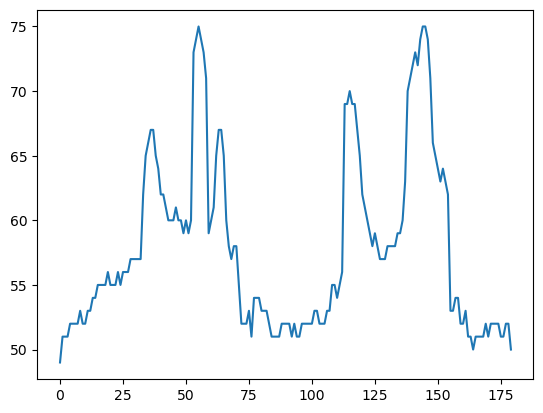

In [163]:
plt.plot(np.fft.irfft(coeffs), label='pred')

In [94]:
def radial_distance(binary, theta):
    height, width = binary.shape
    center = [width // 2, height // 2]
    def test_r(r):
        x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
        if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
            return(False)
        return(binary[int(y_test), int(x_test)])
    # calculate distance to the nearest pixel
    r = max(height, width)
    while(not test_r(r)): # start from edge come inside until hit cell
        r -= 1
    return(r)
        

CPU times: user 259 µs, sys: 84 µs, total: 343 µs
Wall time: 348 µs


49

In [97]:
def test_r(binary, theta, r, viz=False):
    height, width = binary.shape
    center = [width // 2, height // 2]
    x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
    print(f"Testing {x_test}, {y_test}")
    if(viz):
        plt.imshow(binary)
        plt.plot(x_test, y_test, 'rx', markersize=8)
        plt.plot(center[0], center[1], 'go', markersize=5)
    if(x_test >= width or y_test > height or x_test < 0 or y_test < 0):
        print("Out of bounds")
        return(False)
    return(binary[int(y_test), int(x_test)])

[52, 71]
Testing 80.5, 120.363448015713
final: 120, 80
CPU times: user 18.7 ms, sys: 7.59 ms, total: 26.2 ms
Wall time: 20.8 ms


1

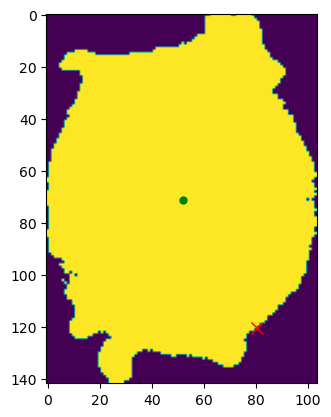

In [100]:
%%time
angle= np.pi/3
r = radial_distance(binary, angle)
test_r(binary, angle, r, True)

In [153]:
%%time
test_angles = np.linspace(0, 2*np.pi, 150)
distances = np.array([radial_distance(binary, angle) for angle in test_angles])

CPU times: user 31.4 ms, sys: 0 ns, total: 31.4 ms
Wall time: 31.6 ms


In [147]:
distances

array([49, 54, 56, 65, 59, 67, 53, 52, 53, 70, 57, 72, 63, 51, 50])

In [152]:
fft_coefficients

(8,)

In [156]:
np.abs(fft_coefficients[:15])

array([8689.        ,   78.89888164,  553.19887243,   51.54753403,
        177.15901665,  121.36703969,  228.78981573,  185.95391389,
        111.20845436,  114.02428067,   49.03708924,   60.45520967,
         87.92142009,   17.47809276,   60.32052281])

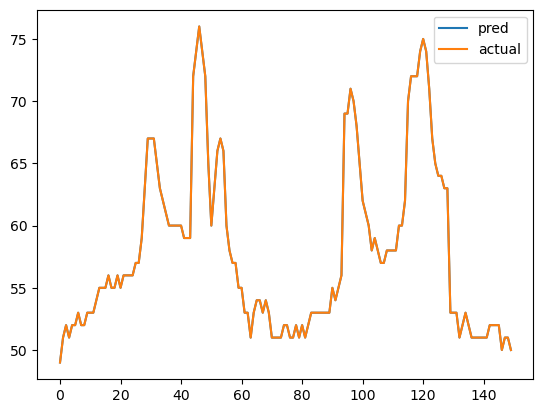

In [154]:
fft_coefficients = np.fft.rfft(distances)
plt.plot(np.fft.irfft(fft_coefficients), label='pred')
plt.plot(distances, label='actual')
plt.legend()
plt.show()

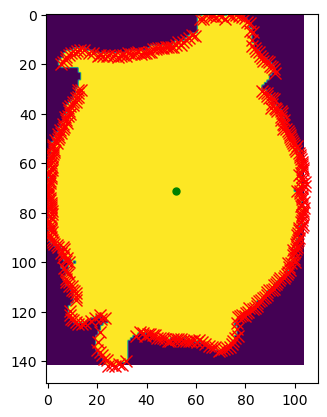

In [106]:
plt.imshow(binary)
height, width = binary.shape
center = [width // 2, height // 2]
plt.plot(center[0], center[1], 'go', markersize=5)
for i in range(360):
    r = distances[i]
    theta = test_angles[i]
    x_test, y_test = center[0] + r*np.cos(theta), center[1] + r*np.sin(theta)
    plt.plot(x_test, y_test, 'rx', markersize=8)



In [9]:
dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
dist_output = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)

NameError: name 'binary' is not defined

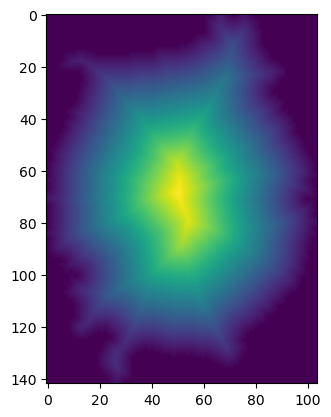

In [41]:
imshow(dist_output)

### Putting it all together

In [20]:
def featurize(cell_data, index):
    image, binary = cell_data['patches'][index], cell_data['masks'][index].astype(np.uint8)
    zernike = mahotas.features.zernike_moments(binary, max(binary.shape)/2, degree=8)
    #zernike = zernike / zernike.sum()
    haralick = mahotas.features.haralick(image.astype(np.uint16)).mean(axis=0)
    #haralick = haralick / haralick.sum()
    shape, info = shape_features(binary, 20)
    #print(f"Zernike: {zernike.shape}, Haralick: {haralick.shape}, Radial Shape: {shape.shape}")
    return(np.concatenate([zernike, haralick, shape]))

In [21]:
mip3

[{'patches': [array([[0.02025658, 0.02565834, 0.02228224, ..., 0.03916273, 0.03308575,
           0.03173531],
          [0.02025658, 0.02295746, 0.01890614, ..., 0.03578663, 0.02970966,
           0.03376097],
          [0.02295746, 0.03848751, 0.02160702, ..., 0.04929102, 0.03241053,
           0.04388926],
          ...,
          [0.21471978, 0.28899392, 0.33220797, ..., 0.05874409, 0.06549629,
           0.07157326],
          [0.23632681, 0.2673869 , 0.30790007, ..., 0.05806887, 0.07022282,
           0.08372721],
          [0.21742066, 0.22619851, 0.26671168, ..., 0.09925726, 0.07157326,
           0.07832546]]),
   array([[0.03241053, 0.0243079 , 0.02295746, ..., 0.04996624, 0.04591492,
           0.05064146],
          [0.02228224, 0.02835922, 0.027684  , ..., 0.0486158 , 0.05064146,
           0.04321404],
          [0.02633356, 0.02700878, 0.02295746, ..., 0.05266712, 0.0486158 ,
           0.04591492],
          ...,
          [0.11276165, 0.09925726, 0.16542876, ..., 0.111

In [66]:
trajectory_features = np.array([featurize(mip3[1], index) for index in range(10)])

In [67]:
trajectory_features.shape

(10, 58)

In [68]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(trajectory_features)

PCA(n_components=3, svd_solver='full')

In [70]:
pca.explained_variance_ratio_

array([0.86144076, 0.11237322, 0.01582193])

In [71]:
pca.components_.shape

(3, 58)

In [72]:
embeddings = pca.fit_transform(trajectory_features)

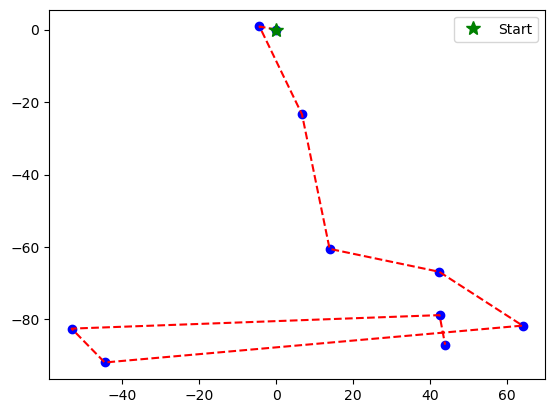

In [73]:
plot_trajectory(mip3[1])

In [74]:
embeddings

array([[-0.98541309, -0.27325282,  0.05565165],
       [-1.05264267, -0.41667195,  0.01039512],
       [-0.71589596, -0.19655802, -0.00191692],
       [-0.00353909,  0.26097913, -0.11785941],
       [-0.10688844,  0.33834534,  0.12814296],
       [-0.05625086,  0.4433365 ,  0.191271  ],
       [ 1.45423494, -0.24478917,  0.02934828],
       [ 1.45832976, -0.29861703,  0.03132811],
       [-0.03551561,  0.15139073, -0.18086823],
       [ 0.04358102,  0.2358373 , -0.14549258]])

In [58]:
c = get_centroids(mip3[1])
c

In [91]:
def compute_trajectory_similarity(t1, t2):
    assert len(t1) == len(t2), "trajectories should be same length"
    def normalized_deltas(t):
        deltas = np.abs(np.array([t[i+1,:2] - t[i,:2] for i in range(len(t)-1)] ))
        return(deltas / np.sum(deltas, axis=0))
    d1 = normalized_deltas(t1)
    d2 = normalized_deltas(t2)
    #print(d1,"\n")
    #print(d2,"\n")
    #print(np.abs(d1-d2), "\n")
    return(np.abs(d1-d2).mean())
    

In [87]:
compute_trajectory_similarity(embeddings, c)

[[0.01542726 0.06290767]
 [0.07727372 0.09654817]
 [0.16346548 0.20068867]
 [0.02371571 0.033935  ]
 [0.01161987 0.04605208]
 [0.3466132  0.30183129]
 [0.00093964 0.02361042]
 [0.3427947  0.19738607]
 [0.01815041 0.03704064]] 

[[0.01523492 0.00762151]
 [0.03851834 0.21131276]
 [0.02499933 0.32318094]
 [0.09926052 0.05505995]
 [0.07546501 0.12940926]
 [0.37833193 0.08859475]
 [0.03000003 0.08139951]
 [0.3331514  0.03240822]
 [0.00503852 0.07101311]] 

[[1.92340378e-04 5.52861618e-02]
 [3.87553788e-02 1.14764590e-01]
 [1.38466150e-01 1.22492265e-01]
 [7.55448014e-02 2.11249510e-02]
 [6.38451310e-02 8.33571801e-02]
 [3.17187345e-02 2.13236535e-01]
 [2.90603883e-02 5.77890982e-02]
 [9.64330064e-03 1.64977848e-01]
 [1.31118849e-02 3.39724613e-02]] 



0.07040773338656366

In [92]:
pca = PCA(n_components=3, svd_solver='full')
def trajectory_shape_loc_comparison(cell_data):
    trajectory_features = np.array([featurize(cell_data, index) for index in range(len(cell_data['boxes']))])
    loc = get_centroids(cell_data)
    embeddings = pca.fit_transform(trajectory_features)
    diff = compute_trajectory_similarity(loc, embeddings)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    # Plot on the first subplot (axs[0])
    axs[0].plot(loc[1:,0], loc[1:,1], 'bo')
    axs[0].plot(loc[:,0], loc[:,1], 'r--')
    axs[0].plot(loc[0,0], loc[0,1], 'g*', markersize=10, label='Start')
    axs[0].set_title('Trajectory of Cell Centroid')
    
    # Plot on the second subplot (axs[1])
    axs[1].plot(embeddings[1:,0], embeddings[1:,1], 'ro')
    axs[1].plot(embeddings[:,0], embeddings[:,1], 'b--')
    axs[1].plot(embeddings[0,0], embeddings[0,1], 'g*')
    axs[1].set_title("Trajectory of Principal Components of Extracted Features")
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    return(diff)

In [ ]:
compute_trajectory_similarity

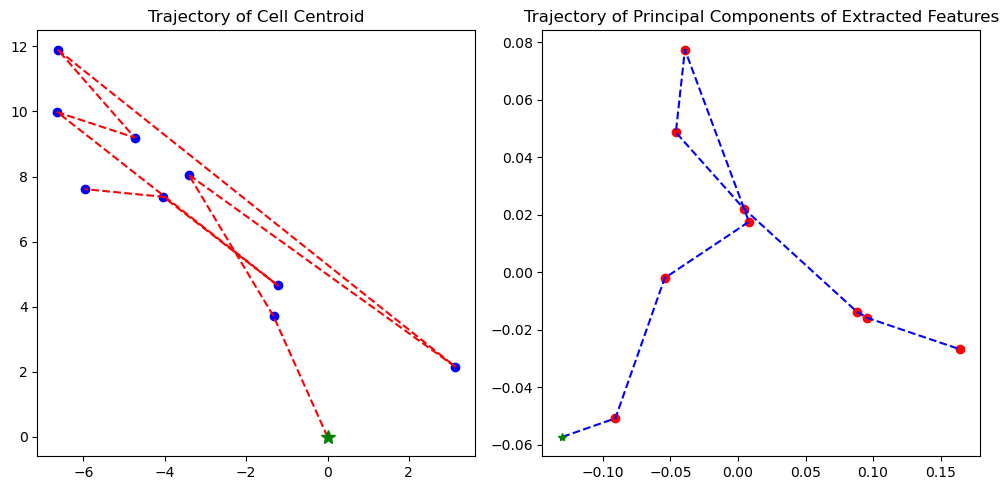

In [93]:
diff = trajectory_shape_loc_comparison(mip3[2])

In [96]:
diff, diff2

(0.06328102897816988, 0.07040773338656366)

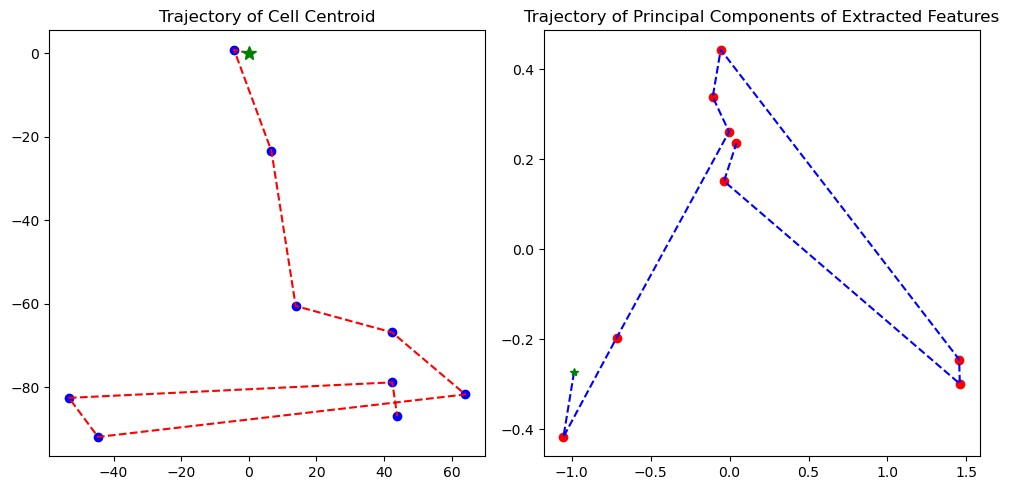

In [95]:
diff2 = trajectory_shape_loc_comparison(mip3[1])

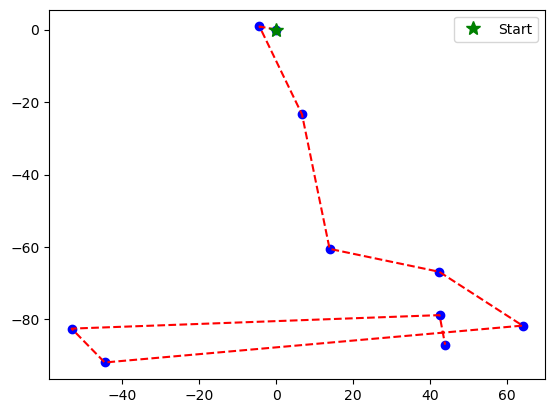

In [38]:
plot_trajectory(mip3[1])

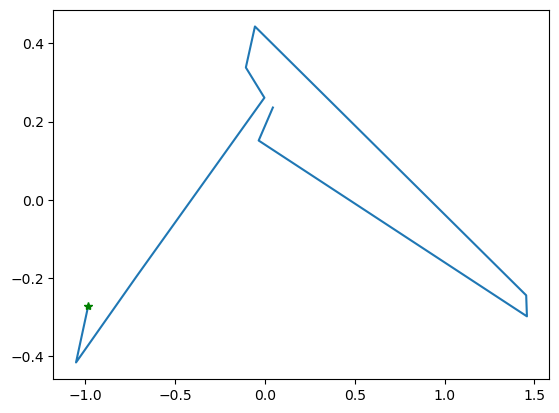

In [35]:
plt.plot(embeddings[:,0], embeddings[:,1])
plt.plot(embeddings[0,0], embeddings[0,1], 'g*')

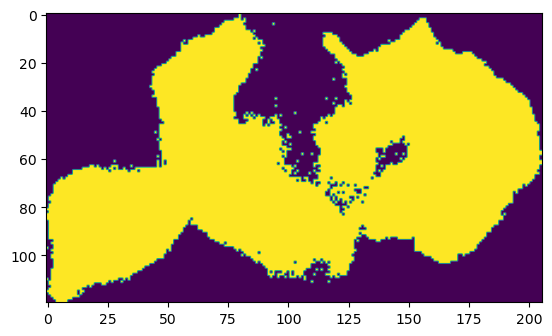

In [92]:
demo = mip6[20]
mask = demo['masks'][1].astype(np.uint8)
m1 = mahotas.features.zernike_moments(mask, max(mask.shape)/2, degree=8)
imshow(mask)

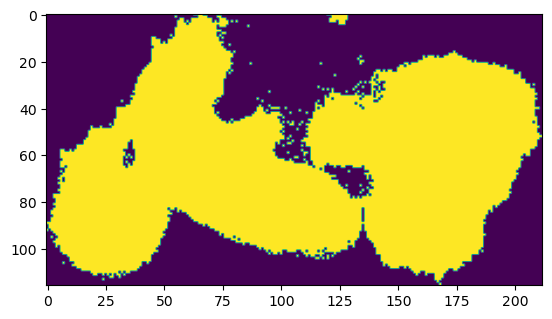

In [93]:
demo = mip6[20]
mask2 = demo['masks'][4].astype(np.uint8)
m2 = mahotas.features.zernike_moments(mask2, max(mask2.shape)/2, degree=8)
imshow(mask2)

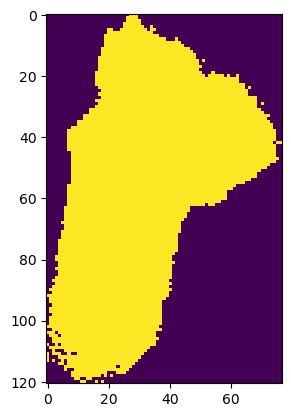

In [91]:
demo = mip6[12]
mask3 = demo['masks'][3].astype(np.uint8)
m3 = mahotas.features.zernike_moments(mask3, max(mask3.shape)/2, degree=8)
imshow(mask3)

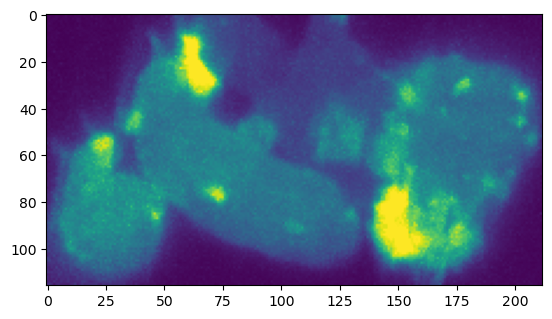

In [98]:
imshow(demo['patches'][4])

In [100]:
imshow(cv2.cvtColor(demo['patches'][4], cv2.COLOR_BGR2GRAY))

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [107]:
demo['patches'][4] * 255

array([[ 3.75      ,  4.09090909,  5.79545455, ...,  5.45454545,
         8.52272727,  5.45454545],
       [ 5.79545455,  7.15909091,  5.11363636, ...,  8.86363636,
        12.27272727,  7.15909091],
       [ 4.09090909,  6.13636364,  6.81818182, ...,  9.88636364,
         5.45454545,  4.77272727],
       ...,
       [32.72727273, 23.18181818, 30.34090909, ...,  5.11363636,
         7.5       ,  5.11363636],
       [27.27272727, 29.65909091, 24.54545455, ...,  6.47727273,
         6.81818182,  8.52272727],
       [33.75      , 40.90909091, 33.75      , ...,  9.20454545,
         4.77272727,  5.79545455]])

In [45]:
patch = (mip3[5]['patches'][4]).astype(np.uint16)

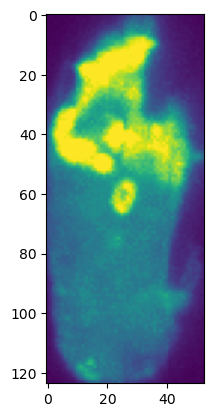

In [44]:
imshow(patch)

In [46]:
mahotas.features.haralick(patch).mean(axis=0)

array([ 0.8651887 ,  0.02929511,  0.72483478,  0.05319408,  0.98535245,
        0.11274418,  0.18348123,  0.43877573,  0.46807083,  0.22157687,
        0.19049379, -0.50413626,  0.51952618])

In [101]:
demo['patches'][4].shape

(116, 212)

In [ ]:


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
features = mahotas.features.haralick(gray).mean(axis=0)

# Dimensionality Reduction and Manifold Learning